In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
PATH = './drive/MyDrive/mlnn2/'

<h1><a href=https://www.kaggle.com/datasets/anshulmehtakaggl/200000-abstracts-for-seq-sentence-classification> Dataset</a>: 20k Medical Abstracts with annotated sentences.</h1>

<h2>Labels include: 'BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'.</h2>

<h1>Task at hand: Sentence classification in medical abstracts.</h1>

<h1>Tables of Content:</h1>

<h2>1. Data loading, preprocessing Part 1.</h2>
<h3>1.1. Loading the dataset into the dataframe.</h3>
<h3>1.2. Transforming the lables.</h3>

---

<h2>2. Baseline model, preprocessing Part 2.</h2>
<h3>2.1. Selecting Multinomial Naive Bayes as a baseline, evaluating it.</h3>
<h3>2.2. Text preprocessing required for Neural Networks.</h3>
<h3>2.3. Re-building preprocessed sentences into the intial 3 sets.</h3>
<h3>2.4. Converting labels to one-hot vectors.</h3>
<h3>2.5. Packaging sentences and their according labels into a batched TF dataset.</h3>

---

<h2>3. The initial NN model that beats the baseline.</h2>
<h3>3.1. Initial 1-D Convolutional architechture.</h3>
<h3>3.2. Investigation of how the number of epochs affects the validation accuracy/loss, detection of overfitting.</h3>
<h3>3.3. Brief discussion of findings.</h3>


---


<h2>4. Systematic approach to hyperparameter selection with implementation of a hand-built Random Search.</h2>
<h3>4.1. Adding an LSTM architechture for additional investigation.</h3>
<h3>4.2. Adding a helper NN builder function used.</h3>
<h3>4.3. Defining the Random Search tuner class.</h3>
<h3>4.4. Defining the parameter grid.</h3>
<h3>4.5. Discussion of results.</h3>
<h3>4.6. Additional experimentation with batch sizes.</h3>
<h3>4.7. Final Model.</h3>

---

<h2>Conclusion.</h2>


<h2> <b>1.1</b> Below is the function that is used to build the datasets from raw text files. Every abstract has an ID, which is prefaced with ### pattern.
<h3> Code is taken from <a href=https://www.kaggle.com/code/ankitajaiwar/abstract-classification-with-tensorflow> here</a> and slightly adjusted. <h3>

In [ ]:
import os
import pandas as pd

def build_set(filename):
    output = []
    # read raw lines
    with open(os.path.join(PATH + '20k_abstracts', filename), 'r') as f:
        raw_lines = f.readlines()

    # process the lines
    for i, line in enumerate(raw_lines):
        # skip the spaces
        if line.isspace():
            continue
        # identify IDs
        if line.startswith('###'):
            abstract_id = line[3:].replace('\n','')
        # insert the text and according labels
        else : output.append({'id': abstract_id, 'label': line.split('\t')[0], 'text': line.split('\t')[1]})

    # convert to a panadas DataFrame
    output = pd.DataFrame(data = output)

    return output

In [ ]:
train_set = build_set('train.txt')
val_set = build_set('dev.txt')
test_set = build_set('test.txt')

In [ ]:
train_set

,id,label,text
0,24293578,3,To investigate the efficacy of 6 weeks of dail...
1,24293578,2,A total of 125 patients with primary knee OA w...
2,24293578,2,Outcome measures included pain reduction and i...
3,24293578,2,Pain was assessed using the visual analog pain...
4,24293578,2,Secondary outcome measures included the Wester...
...,...,...,...
180035,26227186,4,For the absolute change in percent atheroma vo...
180036,26227186,4,"For PAV , a significantly greater percentage o..."
180037,26227186,4,Both strategies had acceptable side effect pro...
180038,26227186,1,"Compared with standard statin monotherapy , th..."


<h2><b>1.2</b> Label encoding using sklearn's LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_set['label'] = le.fit_transform(train_set['label'])
val_set['label']  = le.transform(val_set['label'])
test_set['label']  = le.transform(test_set['label'])

In [ ]:
labels_array_train = train_set['label'].to_numpy()
labels_array_val = val_set['label'].to_numpy()
labels_array_test = test_set['label'].to_numpy()

NUM_CLASSES = len(le.classes_)

In [ ]:
NUM_CLASSES, le.classes_

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

<h2><b>2.1</b> For the baseline, it would be reasonable to use a Multinomial Naive Bayes approach, as it is a simple model with only a few tunable parameters, which makes it very quick to train.</h2>

<h3>The code below uses a simple pipeline, where the text is first vectorized using TF-IDF, and then used train the Naive Bayes.</h3>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

model_0.fit(X = train_set['text'].to_list(), y = labels_array_train)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

<h3>The reference baseline that the deep learning model has to beat is shown below. To monitor how the model performs as it trains more easily, the score achieved on the validation set will be used.</h3>

In [ ]:
model_0.score(X = val_set['text'].to_list(), y = labels_array_val)

0.7317291142592347

In [ ]:
model_0.score(X = test_set['text'].to_list(), y = labels_array_test)

0.7265637962502074

<h2><b>2.2</b> Below is the class I've implemented to deal with vocabulary generation and construction of sentence array corpus, where each array represents a series of integers (calculated word indicies).</h2>

In [ ]:
import re
from collections import Counter
import numpy as np
import nltk
from tqdm import tqdm
import pickle
# import and set the stopwords
# nltk.download('stopwords')

# from nltk.corpus import stopwords

# stop_words = set(stopwords.words("english"))

MAX_LEN = 55

class Vocab:

    # iniatialize our token 2 index dict and maximum sentence length.

    def __init__(self, max_len):
        self.tok2idx = {'<PAD>': 0, '<UNK>' : 1}
        self.max_len = max_len
        self.get_stop_words()
    # returns the length of our vocab.

    def __len__(self):
        return len(self.tok2idx)

    # basic text preprocessing - removing punctuation and gluing the text back together.

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        text = ' '.join([word for word in text.split() if word not in self.stop_words])
        return text

    # tokenization of the text. Neccessary to generate unique indices.

    def tokenize(self, text):
        tokens = []
        for word in text.split():
            tokens.append(word)
        return tokens

    # building our tok2idx vocab with a given corpus

    def build_vocab(self, text_list):
        try:
            self.load_vocab()
        except:
            # start and index 2, since we already have <PAD> and <UNK> in our vocab by default.
            idx = 2
            # our Counter classfrom Python collections library
            self.freqs = Counter()
            for sent in tqdm(text_list):
                # preprocessing step - removing punctuation.
                sent = self.clean_text(sent)
                # tokenize as we go...
                for word in self.tokenize(sent):
                    # count the number of words
                    self.freqs[word] += 1

            for token in self.freqs.keys():
                # set the index of the token
                self.tok2idx[token] = idx
                idx += 1

            self.save_vocab()



    # this is for generating a tensor of padded tensors of integers in the form of a tensor.
    # this is uselful for generating the training and testing sets that the machine can interpret.

    def nums_from_text(self, text_list):

        # initialize our array of this exact size (desired length of our dataset and maximum sentence length)
        text_array = np.empty((len(text_list), self.max_len), dtype=np.int64)

        for array_idx, sent in tqdm(enumerate(text_list)):
            # ignore empty sentences
            if len(sent) == 0:
                continue

            # clean each sentence and tokenize it
            sent = self.clean_text(sent)
            tokens = self.tokenize(sent)

            # generate the inner array, which represents a single sentence
            num_text = np.zeros(self.max_len,  dtype=np.int64)

            for idx, token in enumerate(tokens):
                # truncate if the sentence exceeds max_len
                if idx >= self.max_len:
                    break
                # replace each token with its index
                num_text[idx] = self.tok2idx[token] if token in self.tok2idx.keys() else self.tok2idx['<UNK>']

            # insert the numericalized sentence into the outer tensor
            text_array[array_idx] = num_text

        return text_array

    def save_vocab(self):
        with open(PATH + 'tok2idx.pkl', 'wb') as f:
            pickle.dump(self.tok2idx, f)

    def load_vocab(self):
        with open(PATH + 'tok2idx.pkl', 'rb') as f:
            self.tok2idx = pickle.load(f)

    def get_stop_words(self):
        with open(PATH + 'clinical-stopwords.txt', 'r') as f:
            self.stop_words = f.readlines()


<h3> Class nitialization and building the vocab. </h3>

In [ ]:
combined_vocab = pd.concat([train_set['text'], val_set['text'], test_set['text']], axis=0)
VOCAB = Vocab(MAX_LEN)

VOCAB.build_vocab(combined_vocab)

In [ ]:
VOCAB.tok2idx

{'<PAD>': 0,
 '<UNK>': 1,
 'the': 2,
 'emergence': 3,
 'of': 4,
 'hiv': 5,
 'as': 6,
 'a': 7,
 'chronic': 8,
 'condition': 9,
 'means': 10,
 'that': 11,
 'people': 12,
 'living': 13,
 'with': 14,
 'are': 15,
 'required': 16,
 'to': 17,
 'take': 18,
 'more': 19,
 'responsibility': 20,
 'for': 21,
 'selfmanagement': 22,
 'their': 23,
 'including': 24,
 'making': 25,
 'physical': 26,
 'emotional': 27,
 'and': 28,
 'social': 29,
 'adjustments': 30,
 'this': 31,
 'paper': 32,
 'describes': 33,
 'design': 34,
 'evaluation': 35,
 'positive': 36,
 'outlook': 37,
 'an': 38,
 'online': 39,
 'program': 40,
 'aiming': 41,
 'enhance': 42,
 'skills': 43,
 'gay': 44,
 'men': 45,
 'study': 46,
 'is': 47,
 'designed': 48,
 'randomised': 49,
 'controlled': 50,
 'trial': 51,
 'in': 52,
 'which': 53,
 'australia': 54,
 'will': 55,
 'be': 56,
 'assigned': 57,
 'either': 58,
 'intervention': 59,
 'group': 60,
 'or': 61,
 'usual': 62,
 'care': 63,
 'control': 64,
 'participate': 65,
 'based': 66,
 'on': 67,


<h3> Constructing integer arrays from the computed vocab. </h3>

In [ ]:
text_arrays = VOCAB.nums_from_text(combined_vocab)

240387it [00:53, 4477.98it/s]


In [ ]:
text_arrays

array([[  17,  465,    2, ...,    0,    0,    0],
       [   7,  138,    4, ...,    0,    0,    0],
       [ 482,  483,  144, ...,    0,    0,    0],
       ...,
       [ 186,  124,  187, ...,    0,    0,    0],
       [ 187,  199,  202, ...,    0,    0,    0],
       [3340,    7,   85, ...,    0,    0,    0]])

<h2><b>2.3</b> Splitting the array back into train, val, and test sets.

In [ ]:
x_train = text_arrays[:len(train_set)]
x_val = text_arrays[len(train_set):len(train_set)+len(val_set)]
x_test = text_arrays[len(train_set)+len(val_set):]

<h2><b>2.4</b> Converting the labels into one-hot encoded vectors for building multi-class classification models. </h2>

In [ ]:
import tensorflow.keras as tfk

y_train = tfk.utils.to_categorical(labels_array_train)
y_val = tfk.utils.to_categorical(labels_array_val)
y_test = tfk.utils.to_categorical(labels_array_test)

<h2><b>2.5</b> Packaging the data into a 128-batched TF dataset.</h2>

In [ ]:
import tensorflow as tf

tf_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
tf_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
tf_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

tf_train = tf_train.batch(128).prefetch(tf.data.AUTOTUNE)
tf_val = tf_val.batch(128).prefetch(tf.data.AUTOTUNE)
tf_test = tf_test.batch(128).prefetch(tf.data.AUTOTUNE)

<h3> A helper function, used to visualize the training process. </h3>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_hist(hist):
    figure(figsize=(16, 5), dpi=100)
    plt.subplot(1,3,1)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Accuracy measurements')
    plt.legend(['train', 'val'], loc='lower right')
    plt.subplot(1,3,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Model's losses over time")
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()



<h2><b>3.1</b> The constructor function used to create a 1-D convolutional network, given some parameters.</h2>

In [ ]:
import tensorflow.keras as tfk
from keras.regularizers import l2 as f_l2

def build_conv(num_layers=1, emb_dim=128, filters=32, kernel_size=5, drop_rate=0.0, l2=None, dense_neurons=None, add_batch_norm=False, summary=False):

    model = tfk.Sequential()

    model.add(tfk.layers.Embedding(input_dim = len(VOCAB.tok2idx), output_dim = emb_dim, input_length=MAX_LEN))

    for _ in range(num_layers):
        model.add(tfk.layers.Conv1D(filters, kernel_size=kernel_size, padding='same', activation='relu', kernel_regularizer=f_l2(l2)))
        model.add(tfk.layers.Dropout(drop_rate))
        if add_batch_norm:
            model.add(tfk.layers.BatchNormalization())

    model.add(tfk.layers.GlobalAveragePooling1D())

    if dense_neurons is not None:
        model.add(tfk.layers.Dense(dense_neurons, kernel_regularizer=f_l2(l2)))
        model.add(tfk.layers.Dropout(drop_rate))

    model.add(tfk.layers.Dense(NUM_CLASSES, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer='Adam',
        metrics=['accuracy']
    )

    if summary:
        model.summary()

    return model

<h2><b>3.2</b> Investigating the initial architechture <i>num_layers=1, emb_dim=128, filters=32, kernel_size=4, drop_rate=0.0, l2=None, dense_neurons=None, add_batch_norm=False</i>.</h2>

In [ ]:
conv_model = build_conv(num_layers=1, filters=32, kernel_size=4, summary=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 128)           32210560  
                                                                 
 conv1d (Conv1D)             (None, 55, 32)            16416     
                                                                 
 dropout (Dropout)           (None, 55, 32)            0         
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 32,227,141
Trainable params: 32,227,141
Non-trainable params: 0
____________________________________________

<h3>Start with 5 epochs...</h3>

In [ ]:
conv_hist_0 = conv_model.fit(tf_train, epochs = 5, validation_data = tf_val)

Epoch 1/5
1407/1407 [==============================] - 69s 42ms/step - loss: 0.9588 - accuracy: 0.6637 - val_loss: 0.7397 - val_accuracy: 0.7472
Epoch 2/5
1407/1407 [==============================] - 16s 12ms/step - loss: 0.6853 - accuracy: 0.7649 - val_loss: 0.6734 - val_accuracy: 0.7646
Epoch 3/5
1407/1407 [==============================] - 16s 12ms/step - loss: 0.6231 - accuracy: 0.7886 - val_loss: 0.6511 - val_accuracy: 0.7722
Epoch 4/5
1407/1407 [==============================] - 16s 12ms/step - loss: 0.5849 - accuracy: 0.8056 - val_loss: 0.6403 - val_accuracy: 0.7795
Epoch 5/5
1407/1407 [==============================] - 16s 12ms/step - loss: 0.5559 - accuracy: 0.8184 - val_loss: 0.6358 - val_accuracy: 0.7838


<h3>Then 10...</h3>

In [ ]:
conv_model = build_conv(num_layers=1, filters=32, kernel_size=4, summary=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 55, 128)           32210560  
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 32)            16416     
                                                                 
 dropout_2 (Dropout)         (None, 55, 32)            0         
                                                                 
 global_average_pooling1d_2   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 32,227,141
Trainable params: 32,227,141
Non-trainable params: 0
__________________________________________

In [ ]:
conv_hist_1 = conv_model.fit(tf_train, epochs = 10, validation_data = tf_val)

Epoch 1/10
1407/1407 [==============================] - 45s 31ms/step - loss: 0.9608 - accuracy: 0.6630 - val_loss: 0.7447 - val_accuracy: 0.7472
Epoch 2/10
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6897 - accuracy: 0.7659 - val_loss: 0.6740 - val_accuracy: 0.7669
Epoch 3/10
1407/1407 [==============================] - 16s 12ms/step - loss: 0.6252 - accuracy: 0.7909 - val_loss: 0.6486 - val_accuracy: 0.7777
Epoch 4/10
1407/1407 [==============================] - 17s 12ms/step - loss: 0.5859 - accuracy: 0.8075 - val_loss: 0.6370 - val_accuracy: 0.7824
Epoch 5/10
1407/1407 [==============================] - 17s 12ms/step - loss: 0.5559 - accuracy: 0.8200 - val_loss: 0.6304 - val_accuracy: 0.7865
Epoch 6/10
1407/1407 [==============================] - 17s 12ms/step - loss: 0.5307 - accuracy: 0.8301 - val_loss: 0.6264 - val_accuracy: 0.7899
Epoch 7/10
1407/1407 [==============================] - 17s 12ms/step - loss: 0.5081 - accuracy: 0.8396 - val_loss: 0.6244 -

In [ ]:
conv_model = build_conv(num_layers=1, filters=32, kernel_size=4, summary=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 55, 128)           32210560  
                                                                 
 conv1d_3 (Conv1D)           (None, 55, 32)            16416     
                                                                 
 dropout_3 (Dropout)         (None, 55, 32)            0         
                                                                 
 global_average_pooling1d_3   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 32,227,141
Trainable params: 32,227,141
Non-trainable params: 0
__________________________________________

<h3>Finally, 15.</h3>

In [ ]:
conv_hist_2 = conv_model.fit(tf_train, epochs = 15, validation_data = tf_val)

Epoch 1/15
1407/1407 [==============================] - 45s 31ms/step - loss: 0.9542 - accuracy: 0.6657 - val_loss: 0.7452 - val_accuracy: 0.7450
Epoch 2/15
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6885 - accuracy: 0.7639 - val_loss: 0.6760 - val_accuracy: 0.7640
Epoch 3/15
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6270 - accuracy: 0.7870 - val_loss: 0.6510 - val_accuracy: 0.7715
Epoch 4/15
1407/1407 [==============================] - 17s 12ms/step - loss: 0.5890 - accuracy: 0.8031 - val_loss: 0.6395 - val_accuracy: 0.7776
Epoch 5/15
1407/1407 [==============================] - 18s 12ms/step - loss: 0.5600 - accuracy: 0.8164 - val_loss: 0.6340 - val_accuracy: 0.7830
Epoch 6/15
1407/1407 [==============================] - 16s 12ms/step - loss: 0.5357 - accuracy: 0.8264 - val_loss: 0.6319 - val_accuracy: 0.7848
Epoch 7/15
1407/1407 [==============================] - 16s 12ms/step - loss: 0.5142 - accuracy: 0.8352 - val_loss: 0.6320 -

<h2><b>Figure 1-2.</b><h2>

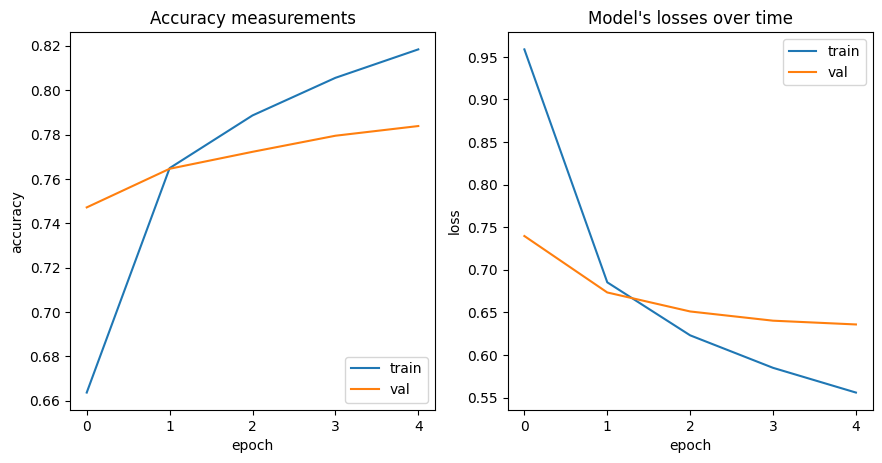

In [ ]:
plot_hist(conv_hist_0)

<h2><b>Figure 3-4.</b><h2>

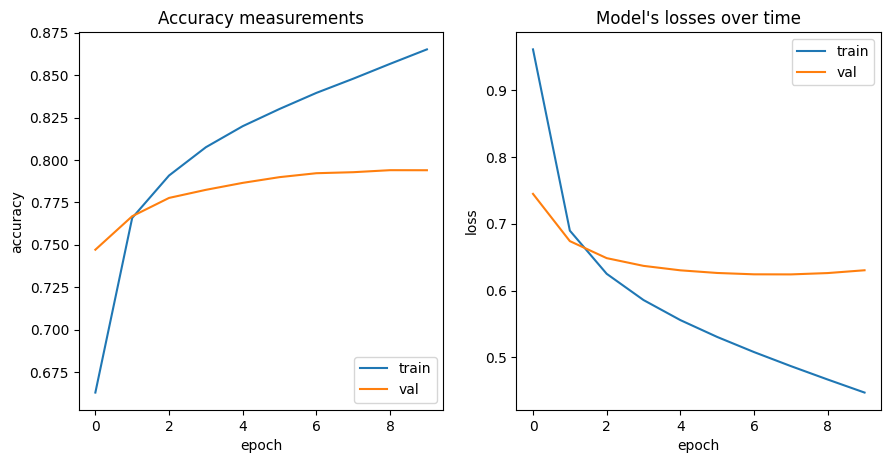

In [ ]:
plot_hist(conv_hist_1)

<h2><b>Figure 5-6.</b><h2>

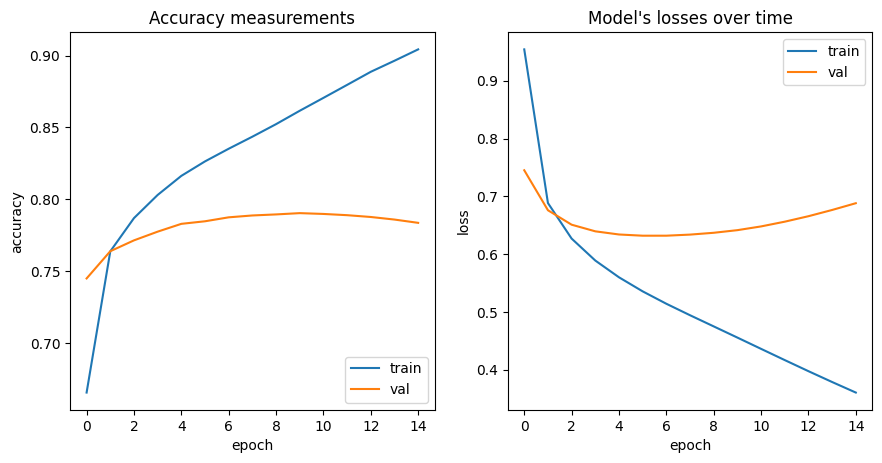

In [ ]:
plot_hist(conv_hist_2)

<h2><b>3.3</b> From the graphs above it can be seen that this simple network outperforms the baseline model by at least 4%. It has a relatively low asymptotic test accuracy, which can be attributed to a relatively high batch-size (selected so to speed up computations). The model starts to noticably overfit at Epoch 11 (Figure 5), although the validation loss starts growing back at Epoch 6 (Figure 6).

<h2><b>4.1</b> The constructor function used to create an LSTM, given some parameters.</h2>

In [ ]:
import tensorflow.keras as tfk
from keras.regularizers import l2 as f_l2

def build_lstm(num_layers=1, emb_dim=256, neurons=64, bidir=False, drop_rate=0.0, l2=None, summary=False):

    l2 = f_l2(l2)

    model = tfk.Sequential()

    model.add(tfk.layers.Embedding(input_dim = len(VOCAB.tok2idx), output_dim = int(emb_dim), input_length=MAX_LEN))

    if bidir:
        for i in range(num_layers):
            # these if statements are used to check if the current layer is last, since it is required that all the LSTM layers but the last
            # have to return_sequences set to True
            if i < num_layers - 1:
                model.add(tfk.layers.Bidirectional(tfk.layers.LSTM(neurons, dropout = drop_rate, return_sequences=True, recurrent_regularizer=l2)))
            elif i == num_layers - 1:
                model.add(tfk.layers.Bidirectional(tfk.layers.LSTM(neurons, dropout = drop_rate, recurrent_regularizer=l2)))
    else:
        for i in range(num_layers):
            if i < num_layers - 1:
                model.add(tfk.layers.LSTM(neurons, dropout = drop_rate, return_sequences=True, recurrent_regularizer=l2))
            elif i == num_layers - 1:
                model.add(tfk.layers.LSTM(neurons, dropout = drop_rate, recurrent_regularizer=l2))

    model.add(tfk.layers.Dense(NUM_CLASSES, activation='softmax'))

    model.compile(
        optimizer = 'Adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    if summary:
        model.summary()

    return model

<h2><b>4.2</b> The constructor function that builds either network from a passed dictionary of parameteres.</h2>

In [ ]:
def build(**kwargs):
    if kwargs['model_type'] == 'LSTM':
        _ = kwargs.pop('model_type', None)
        return build_lstm(**kwargs)

    if kwargs['model_type'] == 'CONV':
        _ = kwargs.pop('model_type', None)
        return build_conv(**kwargs)

    else: return None

<h2><b>4.3</b> The Random Search optimizer class itself. It receives the training and validation data, the parameter grid, number of epochs, labels for validation data, and the maximum number of evaluation per architechture. The methods include the random search itself, the objective function which does the fitting and evaluation. And several helper functions, including functions that are used to save some training statistics and the models directly. </h2>

<h3> Credits for the <a href=https://www.kaggle.com/code/willkoehrsen/intro-to-model-tuning-grid-and-random-search> basic approach</a> to program Random Search.

In [ ]:
import random
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

random.seed(50)

MAX_EVALS = 5

class KerasRandomHpOpt:

    def __init__(self, train, val, params, epochs, y_val, max_evals = MAX_EVALS):
        self.train = train
        self.val = val
        self.y_val = y_val
        self.epochs = epochs
        self.params = params
        self.max_evals = max_evals

    def random_search(self):
        """Random search for hyperparameter optimization"""

        # Dataframe for results
        all_params = self.get_all_params()
        results = pd.DataFrame(columns = ['acc', 'precision', 'recall', 'f1', *all_params, 'iteration'],
                                    index = list(range(MAX_EVALS*len(self.params))))
        row = 0
        for model_i in range(len(self.params)):
            for i in range(self.max_evals):
                # Choose random hyperparameters
                parameters = {k: random.choice(v) for k, v in self.params[model_i].items()}
                print('-'*150)
                print(f"Currently trying out {parameters}...")
                print('-'*150)
                # Evaluate randomly selected hyperparameters
                eval_results = self.objective(parameters)
                results.iloc[row] = {**eval_results, **parameters}
                results.to_excel(PATH + 'record.xlsx')
                row += 1


    def objective(self, params):
        model = build(**params)
        hist = model.fit(self.train, epochs = self.epochs, validation_data = self.val)

        probs = model.predict(self.val)
        preds = tf.argmax(probs, axis=1)
        perf = KerasRandomHpOpt.eval(y_true = self.y_val, y_pred = preds)

        fname = KerasRandomHpOpt.generate_fname(params)

        print('-'*150)
        print('Saving history in ' + fname + '.hist.pkl...')
        KerasRandomHpOpt.save_history(hist.history, fname + '.hist.pkl')

        print('Saving model in ' + fname + '.h5...')
        KerasRandomHpOpt.save_model(model, fname +'.h5')

        # print('Saving model architechture in ' + fname + '.json...')
        # KerasRandomHpOpt.save_architechture(model, fname +'.json')

        return perf

    def get_all_params(self):
        all_params = []
        for params in self.params:
            for param in params:
                if param not in all_params:
                    all_params.append(param)

        return all_params

    @staticmethod
    def eval(y_true,y_pred):
        # Calculate model accuracy
        accuracy = accuracy_score(y_true,y_pred)*100
        # Calculate model precision, recall and f1 score using "weighted" average
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
        results = {'acc': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

        return results

    @staticmethod
    def generate_fname(params):
        fname = ''
        for item in params.items():
            fname += str(item[0]) + '-' + str(item[1]) + '.'

        fname = fname[:-1]
        fname += '_1'

        return fname

    @staticmethod
    def save_history(hist, fname):
        with open(PATH + 'hists/' + fname, 'wb') as f:
            pickle.dump(hist, f)

    @staticmethod
    def save_model(model, fname):
        model.save(PATH + 'models/' + fname)

    @staticmethod
    def save_architechture(model, fname):
        model.to_json(PATH + 'architechtures/' + fname)

<h2><b>4.4</b> The valid parameter grid is shown below. For convolutional architechture, I've decided to experiment with filter sizes, embdedding dimesnions, number of layers, kernel sizes, including an additional dense layer, adding or removing dropout, different values for weight decay, and addition of a BatchNorm layer. The first half of the list is intended to exlore diffrent model fomplexities, while the second half focuses on finding a suitable combination of regularizers. For LSTMs, on top of some of the previously mentioned parameters, it was reasonable to experiment with a number of neurons and bidirectionality.

In [ ]:
import random
random.seed(50)

param_grid = [{
    'model_type': ['CONV'],
    'num_layers': [1,2],
    'emb_dim': [64, 128, 256],
    'filters': [16, 32, 64, 128],
    'kernel_size': [3,4,5,6],
    'drop_rate': [0.0, 0.2],
    'l2': [0.01, 0.02],
    'dense_neurons': [None, 16, 32],
    'add_batch_norm': [True, False]
    },
    {
    'model_type': ['LSTM'],
    'num_layers': [1,2],
    'emb_dim': [64, 128, 256],
    'neurons': [32, 64, 128],
    'drop_rate': [0.0, 0.2],
     'l2': [0.01, 0.02],
     'bidir': [True, False]
     }]


<h3> Quick testing... </h3>

In [ ]:
parameters = {k: random.choice(v) for k, v in param_grid[1].items()}
parameters

{'model_type': 'LSTM',
 'num_layers': 2,
 'emb_dim': 64,
 'neurons': 64,
 'drop_rate': 0.2,
 'l2': 0.01,
 'bidir': True}

In [ ]:
build(**parameters, summary=True)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 55, 64)            16105280  
                                                                 
 bidirectional_9 (Bidirectio  (None, 55, 128)          66048     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 5)                 645       
                                                                 
Total params: 16,270,789
Trainable params: 16,270,789
Non-trainable params: 0
_________________________________________________________________


<h3> Initialize the class and run search. </h3>

In [ ]:
tuner = KerasRandomHpOpt(tf_train, tf_val, param_grid, 5, labels_array_val)

In [ ]:
tuner.random_search()

In [ ]:
import pandas as pd
results = pd.read_excel(PATH + 'record.xlsx').sort_values('acc', ascending=False)

In [ ]:
results

,Unnamed: 0,acc,precision,recall,f1,model_type,num_layers,emb_dim,filters,kernel_size,drop_rate,l2,dense_neurons,add_batch_norm,neurons,bidir
9,9.0,80.289289,0.801757,0.802893,0.800849,LSTM,1.0,64.0,NaN,NaN,0.2,0.01,NaN,NaN,128.0,1.0
7,7.0,80.100622,0.802843,0.801006,0.799914,LSTM,2.0,256.0,NaN,NaN,0.2,0.01,NaN,NaN,128.0,0.0
6,6.0,79.938435,0.796229,0.799384,0.796802,LSTM,2.0,64.0,NaN,NaN,0.0,0.02,NaN,NaN,64.0,1.0
8,8.0,79.746458,0.794606,0.797465,0.795420,LSTM,1.0,64.0,NaN,NaN,0.0,0.01,NaN,NaN,32.0,1.0
5,5.0,79.008341,0.794621,0.790083,0.788520,LSTM,1.0,256.0,NaN,NaN,0.2,0.02,NaN,NaN,32.0,0.0
1,1.0,76.833708,0.767436,0.768337,0.760659,CONV,1.0,256.0,64.0,6.0,0.0,0.01,16.0,0.0,NaN,NaN
3,3.0,76.138620,0.762896,0.761386,0.760519,CONV,2.0,128.0,32.0,6.0,0.2,0.01,16.0,1.0,NaN,NaN
0,0.0,76.204819,0.756748,0.762048,0.752150,CONV,2.0,64.0,64.0,5.0,0.0,0.01,NaN,0.0,NaN,NaN
2,2.0,74.573017,0.749558,0.745730,0.744882,CONV,1.0,128.0,64.0,6.0,0.0,0.02,32.0,1.0,NaN,NaN
4,4.0,74.778234,0.739646,0.747782,0.728716,CONV,2.0,256.0,32.0,4.0,0.0,0.01,16.0,0.0,NaN,NaN


In [ ]:
results.drop(columns=['Unnamed: 0'])

,acc,precision,recall,f1,model_type,num_layers,emb_dim,filters,kernel_size,drop_rate,l2,dense_neurons,add_batch_norm,neurons,bidir
9,80.289289,0.801757,0.802893,0.800849,LSTM,1.0,64.0,NaN,NaN,0.2,0.01,NaN,NaN,128.0,1.0
7,80.100622,0.802843,0.801006,0.799914,LSTM,2.0,256.0,NaN,NaN,0.2,0.01,NaN,NaN,128.0,0.0
6,79.938435,0.796229,0.799384,0.796802,LSTM,2.0,64.0,NaN,NaN,0.0,0.02,NaN,NaN,64.0,1.0
8,79.746458,0.794606,0.797465,0.795420,LSTM,1.0,64.0,NaN,NaN,0.0,0.01,NaN,NaN,32.0,1.0
5,79.008341,0.794621,0.790083,0.788520,LSTM,1.0,256.0,NaN,NaN,0.2,0.02,NaN,NaN,32.0,0.0
1,76.833708,0.767436,0.768337,0.760659,CONV,1.0,256.0,64.0,6.0,0.0,0.01,16.0,0.0,NaN,NaN
3,76.138620,0.762896,0.761386,0.760519,CONV,2.0,128.0,32.0,6.0,0.2,0.01,16.0,1.0,NaN,NaN
0,76.204819,0.756748,0.762048,0.752150,CONV,2.0,64.0,64.0,5.0,0.0,0.01,NaN,0.0,NaN,NaN
2,74.573017,0.749558,0.745730,0.744882,CONV,1.0,128.0,64.0,6.0,0.0,0.02,32.0,1.0,NaN,NaN
4,74.778234,0.739646,0.747782,0.728716,CONV,2.0,256.0,32.0,4.0,0.0,0.01,16.0,0.0,NaN,NaN


<h2><b>4.5</b> From the table above, it can be clearly seen that given the defined parameter grid, all LSTM architechtures outperformed Convolutional architechtures, with a gap of >2% validation accuracy between the worst perfroming LSTM and the best performing ConvNet. Indeed, after looking at the parameter values that were sampled uniformly, it can be seen that for ConvNets the optimizer only generated one addition of dropout, didn't explore the options of having 128 or 16 filters, and mostly focused on 2-layered networks, which when coupled with no dropout and additional dense layers, made the resulting model severly overfit. This overall poor exploration can be attributed to the extremely low number of parameter evaluations, which was to 5 for speeding up the process and presenting the results in time before deadline.</h2>

---

<h2>LSTMs, on the other hand, were more 'lucky' in terms of exploration, having tried each parameter value from the given grid. It can be seen that the best performing model here is quite simple -- the embedding dimension is selected to be 64, and it has only 1 layer. Some complexity is however added with an increased number of neurons and introduction of bidirectionality. It is also important to note that a regularization method called recurrent dropout, would be more suitable for LSTMs. However, it could not be implemeneted here as cuDNN has functionality to specifically accelerate LSTMs and GRUs, and there are some contraints in order for it to work properly, one of which is having recurrent_dropout set to 0.</h2>

---

<h2>Before training it on the whole set and determining the optimal number of epochs, I've decided to experiment with the batch size, which was shown to have shown correlation with asymtotic test accuracy (check <a href=https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e> this</a> experimentation). Additionaly, reducing the batch size might instroduce a regularizing effect (check <a https://axon.cs.byu.edu/papers/Wilson.nn03.batch.pdf> here</a>), by, perhaps, adding some noise during training. It is often treated as a tunable parameter when working with a keras_tuner optimization library. The batch size experimentation will only be carried out for the best performing LSTM model.</h2>

---

<h2>Optimally, I would use a Bayesian Search for this type of problem. Indeed, the BS has its own problems, but its main advantage over the random search is that it does not independently sample from a uniform distribution, but selects parameters based on previous observations, which makes it find near-optimal solutions quicker. However, for the sake of simplicity and lack of time, I've decided to avoid implementing it.</h2>

<h3>Batch size of 64.</h3>

In [ ]:
tf_train_ = tf.data.Dataset.from_tensor_slices((x_train, y_train))
tf_train_64 = tf_train_.batch(64).prefetch(tf.data.AUTOTUNE)

tf_val_ = tf.data.Dataset.from_tensor_slices((x_val, y_val))
tf_val_64 = tf_val_.batch(64).prefetch(tf.data.AUTOTUNE)

tf_test_ = tf.data.Dataset.from_tensor_slices((x_test, y_test))
tf_test_64 = tf_test_.batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
lstm_model_64bs = build_lstm(num_layers=1, emb_dim=64, drop_rate=0.2, l2=0.01, neurons=128, bidir=True)

In [ ]:
lstm_hist_64bs = lstm_model_64bs.fit(tf_train_64, epochs = 5, validation_data = tf_val_64)

Epoch 1/5
2814/2814 [==============================] - 87s 28ms/step - loss: 0.6459 - accuracy: 0.7720 - val_loss: 0.5371 - val_accuracy: 0.8068
Epoch 2/5
2814/2814 [==============================] - 37s 13ms/step - loss: 0.4643 - accuracy: 0.8331 - val_loss: 0.5392 - val_accuracy: 0.8075
Epoch 3/5
2814/2814 [==============================] - 37s 13ms/step - loss: 0.3934 - accuracy: 0.8609 - val_loss: 0.5618 - val_accuracy: 0.8019
Epoch 4/5
2814/2814 [==============================] - 37s 13ms/step - loss: 0.3421 - accuracy: 0.8817 - val_loss: 0.5686 - val_accuracy: 0.8067
Epoch 5/5
2814/2814 [==============================] - 38s 14ms/step - loss: 0.3026 - accuracy: 0.8972 - val_loss: 0.6077 - val_accuracy: 0.8017


<h3>Batch size of 32.</h3>

In [ ]:
tf_train_ = tf.data.Dataset.from_tensor_slices((x_train, y_train))
tf_train_32 = tf_train_.batch(32).prefetch(tf.data.AUTOTUNE)

tf_val_ = tf.data.Dataset.from_tensor_slices((x_val, y_val))
tf_val_32 = tf_val_.batch(32).prefetch(tf.data.AUTOTUNE)

tf_test_ = tf.data.Dataset.from_tensor_slices((x_test, y_test))
tf_test_32 = tf_test_.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
lstm_model_32bs = build_lstm(num_layers=1, emb_dim=64, drop_rate=0.2, l2=0.01, neurons=128, bidir=True)

In [ ]:
lstm_hist_32bs = lstm_model_32bs.fit(tf_train_32, epochs = 5, validation_data = tf_val_32)

Epoch 1/5
5627/5627 [==============================] - 113s 19ms/step - loss: 0.6183 - accuracy: 0.7790 - val_loss: 0.5298 - val_accuracy: 0.8101
Epoch 2/5
5627/5627 [==============================] - 76s 13ms/step - loss: 0.4568 - accuracy: 0.8360 - val_loss: 0.5314 - val_accuracy: 0.8108
Epoch 3/5
5627/5627 [==============================] - 74s 13ms/step - loss: 0.3875 - accuracy: 0.8640 - val_loss: 0.5495 - val_accuracy: 0.8071
Epoch 4/5
5627/5627 [==============================] - 74s 13ms/step - loss: 0.3344 - accuracy: 0.8857 - val_loss: 0.5704 - val_accuracy: 0.8081
Epoch 5/5
5627/5627 [==============================] - 74s 13ms/step - loss: 0.2888 - accuracy: 0.9038 - val_loss: 0.6235 - val_accuracy: 0.8018


<h2><b>Figures 7-8.</b>Model's losses and accuracy measurements with a batch_size = 64.</h2>

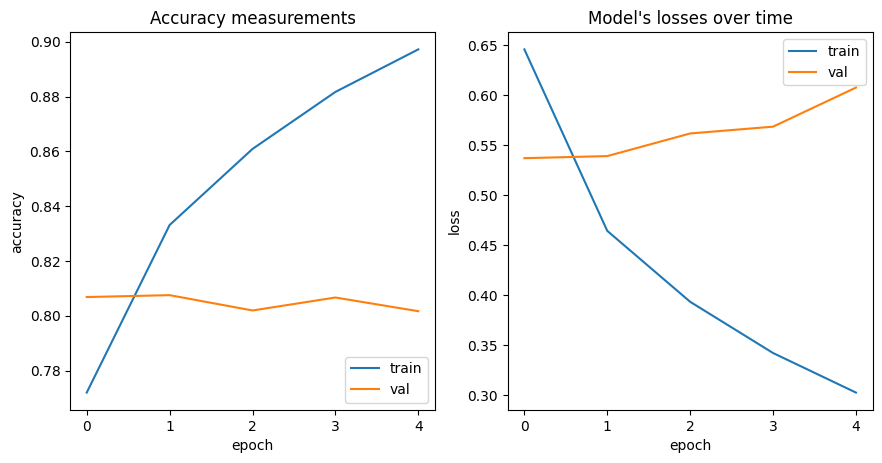

In [ ]:
plot_hist(lstm_hist_64bs)

<h2><b>Figures 9-10.</b> Model's losses and accuracy measurements with a batch_size = 32.</h2>

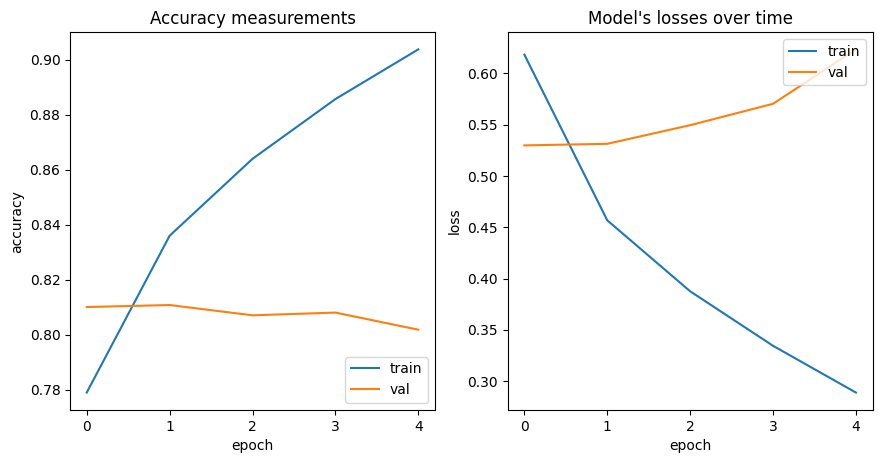

In [ ]:
plot_hist(lstm_hist_32bs)

<h2><b>4.6</b> As can be seen from Figures 7-8, the batch size does have a somewhat regularizing effect, and decreasing it even further (Figures 9-10) leads to higher achieved val accuracy. It is important to note that validation loss is not necesarrily inversly correlated with accuracy, so its increase does not necessarily mean that accuracy has to decrease as well. For instance, it can happen when the network assigns higher and higher probability for a class that was initially classified incorrectly. </h2>

<h2><b>4.7</b> Because of resource contraints Google Colab has, the final model will be trained with a larger batch size of 128 that was used initially, at the expense of lower test accuracy and greater overfitting, but for the purposes of this demonstration, I believe it would be sufficient. </h2>

In [ ]:
x_train_ = np.concatenate((x_train, x_val))
y_train_ = np.concatenate((y_train, y_val))

tf_train_ = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
tf_train_ = tf_train_.batch(128).prefetch(tf.data.AUTOTUNE)

tf_test_ = tf.data.Dataset.from_tensor_slices((x_test, y_test))
tf_test_ = tf_test_.batch(128).prefetch(tf.data.AUTOTUNE)

In [ ]:
lstm_model_128bs = build_lstm(num_layers=1, emb_dim=64, drop_rate=0.2, l2=0.01, neurons=128, bidir=True)

In [ ]:
lstm_hist_128bs = lstm_model_128bs.fit(tf_train_, epochs = 5, validation_data = tf_test_)

Epoch 1/5
1643/1643 [==============================] - 72s 42ms/step - loss: 0.6731 - accuracy: 0.7680 - val_loss: 0.5384 - val_accuracy: 0.8066
Epoch 2/5
1643/1643 [==============================] - 24s 15ms/step - loss: 0.4679 - accuracy: 0.8316 - val_loss: 0.5421 - val_accuracy: 0.8019
Epoch 3/5
1643/1643 [==============================] - 24s 15ms/step - loss: 0.4034 - accuracy: 0.8563 - val_loss: 0.5629 - val_accuracy: 0.7967
Epoch 4/5
1643/1643 [==============================] - 24s 15ms/step - loss: 0.3531 - accuracy: 0.8754 - val_loss: 0.5929 - val_accuracy: 0.7969
Epoch 5/5
1643/1643 [==============================] - 24s 15ms/step - loss: 0.3145 - accuracy: 0.8917 - val_loss: 0.6341 - val_accuracy: 0.7909


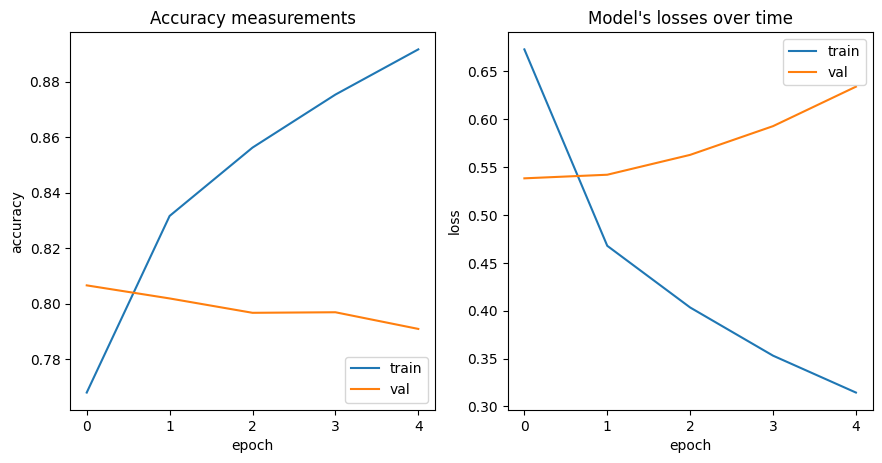

In [ ]:
plot_hist(lstm_hist_128bs)

<h2> The model started overfitting right after the first epoch, so with these settings, it should be trained for 1 epoch.</h2>

<h1>Conclusion</h1>
<h2>In this mini-project I have described a baseline to be a Multinomial Naive Bayes, which achieved the accuracy of ~73%, selected a simple NN model that beat the baseline by ~6%, implemented a Random Search class, which performed automatic experimentation with the provided hyperparameter settings, and finally described the LSTM architechture, which achieved >80% accuracy. The main takeaway from this experimentation is that it is extremely important to balance the complexity of the model with the proper selection of regularization parameters and batch sizes to achieve the best results.